In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Load dataset**

In [2]:
dataset = 'movielens'

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

n_users, n_items, n_samples_train, n_samples_test

(943, 1682, 159619, 40381)

#### **Defining collaborative filtering**

In [3]:
class CF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

class CFD(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CFD, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.drop_u = nn.Dropout(p = 0.3)
        self.drop_i = nn.Dropout(p = 0.3)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        u = self.drop_u(u)
        i = self.drop_i(i)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

class GMF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.h = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i)
        x = self.h(dot)
        return torch.sigmoid(x)

class GMFD(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(GMFD, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.h = nn.Linear(n_factors, 1)
        self.drop_u = nn.Dropout(p = 0.2)
        self.drop_i = nn.Dropout(p = 0.2)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        u = self.drop_u(u)
        i = self.drop_i(i)
        dot = (u * i)
        x = self.h(dot)
        return torch.sigmoid(x)

def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Test the model**

In [4]:
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

ratings_np = ratings.detach().to('cpu').int().numpy()
ratings_test_np = ratings_test.detach().to('cpu').int().numpy()

#### **Test GMFD**

max meta grad:  0.00016304224845953286
min meta grad:  -inf
Training accuracy:  0.8734987378120422
Training AUC:  0.9473852879023851
Validation accuracy:  0.812684178352356
Validation AUC:  0.8909770460232569


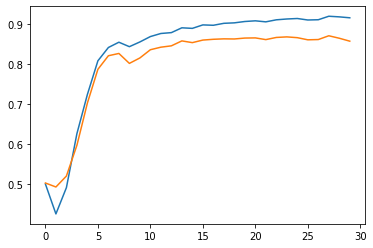

In [31]:
n_factors = 16
T = 30
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = GMFD(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing GMF**

max meta grad:  0.0003827007603831589
min meta grad:  -inf
Training accuracy:  0.9159999489784241
Training AUC:  0.9753514114878358
Validation accuracy:  0.7791040539741516
Validation AUC:  0.8561287338697806


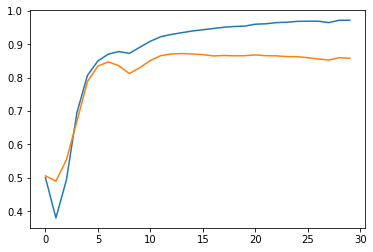

In [32]:
n_factors = 16
T = 30
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = GMF(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing CFD**

max meta grad:  0.00024571456015110016
min meta grad:  -inf
Training accuracy:  0.8331401348114014
Training AUC:  0.9145737757319232
Validation accuracy:  0.7985934019088745
Validation AUC:  0.8782287424562092


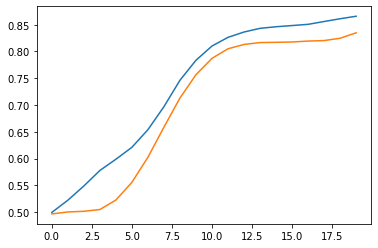

In [15]:
n_factors = 16
T = 20
seed = 50
lr = 0.3

torch.manual_seed(seed)
model = CFD(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).reshape(ratings.shape).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).reshape(ratings_test.shape).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items).reshape(ratings.shape)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items).reshape(ratings.shape)
    y_hat_test = model(users_test, items_test).reshape(ratings_test.shape)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing CF**

max meta grad:  inf
min meta grad:  -inf
Training accuracy:  0.9508579969406128
Training AUC:  0.9899306658900513
Validation accuracy:  0.769842267036438
Validation AUC:  0.8300272594573377


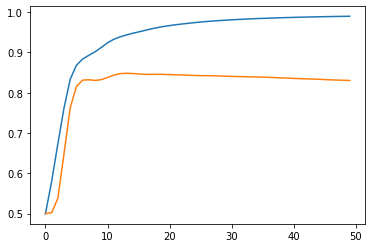

In [36]:
n_factors = 16
T = 50
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = CF(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()